# NREL MIDC station network

The [Measurement and Instrumentation Data Center (MIDC)](https://midcdmz.nrel.gov/) is operated by NREL and provides irradiance and meteorological data from a number of ground stations in the U.S. The stations vary in quality, with some stations measuring all three components with high-quality instruments and other stations featuring a rotating shadow band pyranometer.

The most notable station is the [Baseline Measurement System (BMS)](https://midcdmz.nrel.gov/apps/sitehome.pl?site=BMS) at NREL's [Solar Radiation Research Laboratory (SRRL)](https://www.nrel.gov/esif/solar-radiation-research-laboratory.html) outside of Denver, Colorado. The BMS features the World's largest collection of operating pyranometers and pyrheliometers. A number of sky imagers, PV reference cells, and spectral radiometers are also located at the site. Instruments at the BMS are cleaned each weekday and frequently calibrated. Thus, due to the large collection of co-located instruments, the BMS is ideal for comparing different types of instruments.

Note, the MIDC includes several inactive stations. Also, several of the active stations are not cleaned or calibrated frequently. See the map below for the locations of the stations. Note, the SolarStations listing only includes the SRRL BMS, SOLARTAC, and Flatirons M2 sites, as these measures all three irradiance components and are considered "high-quality".

In [63]:
import pandas as pd
pd.set_option('display.max_rows', None)

stations_midc_url = 'https://midcdmz.nrel.gov/apps/data_api_doc.pl?_idtextlist_'
stations = pd.read_csv(stations_midc_url)
stations = stations.rename(columns={
    'STATION_ID': 'Station Identifier',
    'STATION_FULLNAME': 'Station full name',
    'STATION_SHORTNAME': 'Station Abbreviation',
    'LATITUDE_DEG': 'Latitude',
    'LONGITUDE_DEG': 'Longitude',
    'ELEVATION_M': 'Elevation'})

stations

,Station Identifier,Station full name,Station Abbreviation,RESERVED,Latitude,Longitude,Elevation,ACTIVE
0,RCS,ARM Radiometer Characterization System (RCS),ARM RCS,0,36.606000,-97.486000,320.0,0
1,BS,Bluefield State College,BSC,0,37.265000,-81.240000,803.0,0
2,EC,Elizabeth City State University,ECSU,0,36.282000,-76.216000,26.0,0
3,HSU,Humboldt State University (SoRMS),HSU SoRMS,0,40.876000,-124.080000,36.0,1
4,LRSS,Lowry Range Solar Station (RSR),LRSS,0,39.607010,-104.580170,1860.0,0
5,NWTC,NREL Flatirons Campus (M2),Flatirons M2,0,39.910600,-105.234700,1855.0,1
6,SRRLASI,NREL SRRL All Sky Imager (ASI-16),SRRL ASI-16,0,39.742300,-105.178500,1828.8,1
7,AOCS,NREL Solar Radiation Research Laboratory (AOCS),SRRL AOCS,0,39.742300,-105.178500,1828.8,0
8,AODSRRL0E,NREL Solar Radiation Research Laboratory (AOD ...,SRRL AOD ESR0,0,39.742300,-105.178500,1828.8,1
9,AODSRRL1E,NREL Solar Radiation Research Laboratory (AOD ...,SRRL AOD ESR1,0,39.742300,-105.178500,1828.8,1


```{margin} Station metadata
Click the plus symbol above to see a table of the stations and their metadata.
```

In [58]:
import folium
from folium import plugins

EsriImagery = "https://server.arcgisonline.com/ArcGIS/rest/services/World_Imagery/MapServer/tile/{z}/{y}/{x}"
EsriAttribution = "Tiles &copy; Esri &mdash; Source: Esri, i-cubed, USDA, USGS, AEX, GeoEye, Getmapping, Aerogrid, IGN, IGP, UPR-EGP, and the GIS User Community"

# Create Folium map
m = folium.Map(
    location=[35, -107],
    zoom_start=3, min_zoom=1, max_bounds=True,
    control_scale=True,  # Adds distance scale in lower left corner
    tiles='openstreetmap',
)

# Function for determining station color
def marker_color(row):
    if row['ACTIVE'] == 1:  # active station
        color = 'green'
    else:  # inactive/closed station
        color = '#FA8072'
    return color

# SRRL, STAC, and UoE has multiple stations with same latitude/longitude
# append the main stations to the end, so they plot ontop
stations_to_plot = stations.\
    append(stations[stations['Station Identifier'] == 'UOSMRL']).\
    append(stations[stations['Station Identifier'] == 'BMS']).\
    append(stations[stations['Station Identifier'] == 'STAC'])

# Add each station to the map
for index, row in stations_to_plot.iterrows():
    color = marker_color(row)
    folium.CircleMarker(
        location=[row['Latitude'], row['Longitude']],
        popup=f"{row['Station full name']} ({row['Station Identifier']})",
        tooltip=f"{row['Station full name']} ({row['Station Identifier']})",
        radius=5, color=color,
        fill_color=color, fill=True).add_to(m)

folium.raster_layers.TileLayer(EsriImagery, name='World imagery', attr=EsriAttribution).add_to(m)
folium.LayerControl(position='topright').add_to(m)

# Additional options and plugins
plugins.Fullscreen(position='bottomright').add_to(m)  # Add full screen button to map
folium.LatLngPopup().add_to(m)  # Show latitude/longitude when clicking on the map

# Create legend
legend_html = """
<div style="position:fixed;
     top: 10px; 
     left: 10px; 
     width: 120px; 
     height: 68px; 
     border:2px solid grey; 
     z-index: 9999;
     background-color:#f2efe9;
     font-size:14px;">
     &nbsp;<b>Station markers</b><br>
     &nbsp;<i class="fa fa-circle fa-1x" style="color:green"></i>&nbsp;Active<br>
     &nbsp;<i class="fa fa-circle fa-1x" style="color:red"></i>&nbsp;Inactive<br>
</div>"""
m.get_root().html.add_child(folium.Element(legend_html))  # Add Legend to map

# Show the map
m

## Data retrieval
Data from the MIDC can be retrieved from the MIDC website or using the [MIDC raw data API](https://midcdmz.nrel.gov/apps/data_api_doc.pl).

```{admonition} Note
If you use data from the MIDC in any publication, make sure to cite it. The citation for the BMS site is:

Andreas, A.; Stoffel, T.; (1981). NREL Solar Radiation Research Laboratory (SRRL): Baseline
Measurement System (BMS); Golden, Colorado (Data); NREL Report No. DA-5500-56488.
http://dx.doi.org/10.5439/1052221
```

Conveniently, the [pvlib-python](https://pvlib-python.readthedocs.io/en/stable/generated/pvlib.iotools.read_midc_raw_data_from_nrel.html#pvlib.iotools.read_midc_raw_data_from_nrel) library features a wrapper around the API making retrieving data a breeze. The use of the function is shown below, demonstrating how to retrieve five days of data from the BMS:

In [46]:
import pvlib

data = pvlib.iotools.read_midc_raw_data_from_nrel(
    site='BMS',  # station identifier
    start=pd.Timestamp(2020,6,1),
    end=pd.Timestamp(2020,6,5))

data.iloc[:5, 5:10]  # show a subset of the data

,CR3000 Zen Angle [degrees],Global LI-200 [W/m^2],Global CMP22 (vent/cor) [W/m^2],Global RG780 PSP [W/m^2],Global CM3 (cor) [W/m^2]
2020-06-01 00:00:00-07:00,118.122,0.015113,-1.16558,-5.33149,-0.400916
2020-06-01 00:01:00-07:00,118.121,0.085907,-1.16301,-5.02037,0.580222
2020-06-01 00:02:00-07:00,118.118,0.072543,-1.13942,-4.57866,1.314890
2020-06-01 00:03:00-07:00,118.115,0.012090,-1.13952,-4.27871,1.144530
2020-06-01 00:04:00-07:00,118.110,0.006046,-1.15379,-4.07609,0.850172


<br>

The retrieved BMS dataset contains numerous instruments measuring the same irradiance component. Let's, for example, compare the measured global horizontal irradiance (GHI) measured by a high-quality CMP22 pyranometer with that of a low-cost CM3 pyranometer:

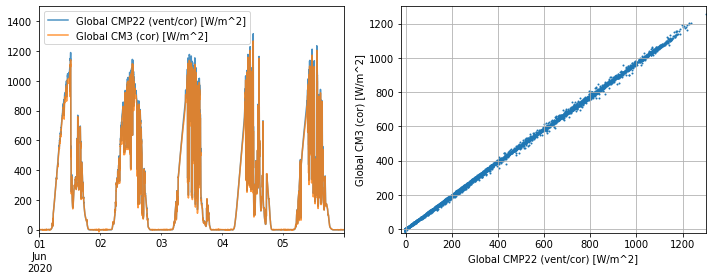

In [38]:
import matplotlib.pyplot as plt

fig, axes = plt.subplots(ncols=2, figsize=(10,4))
# plot both measurement as a time-series
data[['Global CMP22 (vent/cor) [W/m^2]', 'Global CM3 (cor) [W/m^2]']].plot(
    ax=axes[0], alpha=0.8, ylim=[-20, 1500])
# compare measurements with a scatter plot
data.plot.scatter(ax=axes[1], s=1, grid=True,
                  x='Global CMP22 (vent/cor) [W/m^2]',
                  y='Global CM3 (cor) [W/m^2]',
                  xlim=[-20, 1300], ylim=[-20, 1300])
fig.tight_layout()